# Imports

In [1]:
from lifelines 				 import CoxPHFitter
from sklearn.preprocessing import OneHotEncoder
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import pandas            as pd
import matplotlib
import sklearn
import copy
import shap
import sys
import os

# Workspace path.
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'

sys.path.append(main_path)
# from models.clustering.cox_proportional_hazard_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
# from models.visualization.attention_maps import *
# from models.clustering.data_processing import *


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Plot figures

In [2]:
from lifelines.plotting import add_at_risk_counts
# Survival libs.
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

def plot_KM_high_low(high_risk_df, low_risk_df, ax_title, ax, event_ind_field, event_data_field, max_months=None):
    

    fontsize_title  = 15
    fontsize_labels = 11
    fontsize_ticks  = 11
    fontsize_legend = 10
    l_markerscale   = 8
    l_box_w         = 3
    


    kmf_l = KaplanMeierFitter(label='Low-Risk')
    kmf_l.fit(low_risk_df[event_data_field].astype(float),  event_observed=low_risk_df[event_ind_field].astype(float))
    kmf_h = KaplanMeierFitter(label='High-Risk')
    kmf_h.fit(high_risk_df[event_data_field].astype(float), event_observed=high_risk_df[event_ind_field].astype(float))

    kmf_l.plot_survival_function(show_censors=True, ci_show=True, ax=ax)
    kmf_h.plot_survival_function(show_censors=True, ci_show=True, ax=ax)

    ax.set_title(ax_title)
    ax.set_ylim([0.0,1.10])
    ax.patch.set_linewidth(1)
    if max_months is not None:
        ax.set_xlim([0.0, max_months])
    
    for ticks in [ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()]:
        for tick in ticks:
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label1.set_fontweight('bold')

    
    ax.set_title(ax_title, fontsize=fontsize_title, fontweight='bold', y=1.02)

    ax.set_xlabel('Time (Month)',         fontsize=fontsize_labels)
    ax.set_ylabel('Survival Probability', fontsize=fontsize_labels)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)

    legend = ax.legend(loc='best', markerscale=l_markerscale, title='Risk Group', prop={'size': fontsize_legend})
    legend.get_title().set_fontsize(fontsize_legend)
    legend.get_frame().set_linewidth(l_box_w)
    for line in legend.get_lines():
        line.set_linewidth(l_markerscale)
    
    add_at_risk_counts(kmf_l, kmf_h, ax=ax, ypos= -0.8)
    plt.tight_layout()


def plot_k_fold_cv_KM(high_risk, low_risk, title, max_months, event_ind_field, event_data_field, file_path=None):
    results = logrank_test(high_risk[event_data_field].astype(float), low_risk[event_data_field].astype(float), event_observed_A=high_risk[event_ind_field].astype(float), event_observed_B=low_risk[event_ind_field].astype(float))
    title_add = 'P-Value: %.2E ' % (Decimal(results.p_value))
    mosaic = '''A'''
    fig = plt.figure(figsize=(12,6.6), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(mosaic)
    plot_KM_high_low(high_risk, low_risk, ax_title=title + title_add, ax=ax_dict['A'], event_ind_field=event_ind_field, event_data_field=event_data_field, max_months=max_months)
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return results.p_value

def save_fold_KMs(train_risk, risk_groups, additional_risk, resolution, groupby, cis, event_ind_field, event_data_field, max_months, cox_cluster_path):
    train_cindex = np.round(cis[0],2)
    title = 'Leiden %s Train Set \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_train.jpg' % (str(groupby).replace('.', 'p')))
    train_pval = plot_k_fold_cv_KM(train_risk[1], train_risk[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)
   
    test_cindex = np.round(cis[1],2)
    # title = 'Leiden %s\nC-Index Test: %s \n' % (resolution, test_cindex)
    title = 'Leiden %s Test Set \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_test.jpg' % (str(groupby).replace('.', 'p')))
    test_pval = plot_k_fold_cv_KM(risk_groups[1], risk_groups[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    additional_pval = None
    
    additional_cindex = np.round(cis[2],2)
    # title = 'Leiden %s\nC-Index Additional (TCGA): %s \n' % (resolution, additional_cindex)
    title = 'Leiden %s Additional (TCGA) \n' % (resolution)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_additional.jpg' % (str(groupby).replace('.', 'p')))
    additional_pval = plot_k_fold_cv_KM(additional_risk[1], additional_risk[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    return train_pval, test_pval, additional_pval

# Divide group into X buckets.
def get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2):
	labels_buckets = list(range(q_buckets))
	high_lows = list()
	for index, set_data in enumerate(zip(datas, predictions)):
		data, prediction = set_data
		if data[0] is None:
			high_lows.append((None, None, None))
			continue
		current_hazard                     = data[0].copy(deep=True)
		current_hazard['hazard']           = prediction[0]
		if index == 0:
			# median_cutoff is the median hazard value of the train set
			median_cutoff = current_hazard['hazard'].median()
		# If the hazard is higher than the median, it is high risk, otherwise it is low risk.
		current_hazard['h_bin']            = (current_hazard['hazard']>median_cutoff)*1
		current_hazard['h_bin_%s' % fold]  = (current_hazard['hazard']>median_cutoff)*1
		current_low_risk_slides            = current_hazard[current_hazard['h_bin']==labels_buckets[0]][matching_field].values
		current_high_risk_slides           = current_hazard[current_hazard['h_bin']==labels_buckets[1]][matching_field].values

		high_risk_df = current_hazard[current_hazard[matching_field].isin(current_high_risk_slides)].copy(deep=True)
		low_risk_df  = current_hazard[current_hazard[matching_field].isin(current_low_risk_slides)].copy(deep=True)
		high_lows.append((high_risk_df, low_risk_df, current_hazard))
	return high_lows


# Combine Risk Groups over the folds. In the case of additional dataset, mayority vote over folds.
def combine_risk_groups(train_risk, test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field):
	# For test set, combine the risk groups.
	train_risk[1] = pd.concat([train_risk[1], high_lows[0][1][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)
	train_risk[0] = pd.concat([train_risk[0], high_lows[0][0][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)



	test_risk[1] = pd.concat([test_risk[1], high_lows[1][1]], ignore_index=True)
	test_risk[0] = pd.concat([test_risk[0], high_lows[1][0]], ignore_index=True)

	# For additional dataset, combine the risk groups.
	if high_lows[2][2] is not None:
		additional_risk[1] = pd.concat([additional_risk[1], high_lows[2][1]], ignore_index=True)
		additional_risk[0] = pd.concat([additional_risk[0], high_lows[2][0]], ignore_index= True)
	else:
		additional_risk = None
	return train_risk, test_risk, additional_risk

In [16]:
def plot_shap_figure_simple(shap_cv, text1='', text2='', plot_size=(25,20), fontsize_labels=24, fontsize_ticks=22, offset=150, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True), path=None):
    text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2

    sns.set_theme(style='white')
    shap.plots.beeswarm(shap_cv, max_display=15,
                        color_bar_label='HPC Contribution',
                        color=cmap_bar, plot_size=plot_size, show=False)
    figure = plt.gcf()
    figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
    figure.axes[1].set_ylabel('HPC Contribution', fontweight='bold', fontsize=fontsize_labels)
    for ax in [figure.axes[0], figure.axes[1]]:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)

    plt.savefig(path, bbox_inches='tight')

In [3]:
def plot_shap_decision(shap_base_values, shap_values, dataset_samples_features, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim=None, path=None):

    if low_risk_ind is None:
        risk_ind = high_risk_ind
    elif high_risk_ind is None:
        risk_ind = low_risk_ind
    else:
        risk_ind = np.concatenate([low_risk_ind.values, high_risk_ind.values])

    # Legend handling.
    if show_legend and low_risk_ind is not None and high_risk_ind is not None:
        legend_labels = ['Low Risk' for s in range(low_risk_ind.values.shape[0])]
        legend_labels.extend(['High Risk' for s in range(high_risk_ind.values.shape[0])])
    else:
        legend_labels = None
    # Number of HPCs to display
    if num_features == 'all':
        feature_display_range = slice(None, None, -1)
    else:
        feature_display_range = slice(-1, -num_features, -1)

    shap_base_plot = [shap_base_values[risk_ind[0]]]
    shap_cv_values = np.array(shap_values[risk_ind[0]].reshape((1,-1)))
    # data_values    = np.array(dataset_samples_features.loc[risk_ind[0]].values.reshape((1,-1)))

    for ind in risk_ind[1:]:        
        shap_base_plot.append(shap_base_values[ind])
        shap_cv_values = np.concatenate([shap_cv_values, shap_values[ind].reshape((1,-1))])
        # data_values    = np.concatenate([data_values, dataset_samples_features.loc[ind].values.reshape((1,-1))])

    # SHAP decision plot.
    shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, features=dataset_samples_features.loc[risk_ind], xlim=xlim,
                    feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')

    # Ascetic fixes.
    figure = plt.gcf()
    # set color palette
    plt.set_cmap('Set1')
    figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
    figure.axes[0].set_ylabel('Histomorpholical Phenotype Cluster', fontweight='bold', fontsize=fontsize_labels)
    for ax in [figure.axes[0]]:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for axis in ['bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
    
    # Legend for High/Low risk group.
    if show_legend and low_risk_ind is not None and high_risk_ind is not None:
        legend = figure.axes[0].legend_
        new_handles = [legend.legend_handles[0], legend.legend_handles[-1]]
        new_texts   = [legend.get_texts()[0]._text, legend.get_texts()[-1]._text]
        map_dict = dict()
        for handle, text in zip(legend.legend_handles, legend.get_texts()):
            map_dict[handle._label] = text._text

        legend.remove()
        legend = figure.axes[0].legend(new_handles, new_texts, loc='lower right')
        legend.get_frame().set_linewidth(l_box_w)
        for i, handler in enumerate(legend.legend_handles):
            handler.set_linewidth(5)
            handler.set_color('Blue')
            if i!=0:
                handler.set_color('Red')

        for text in legend.get_texts():
            text.set_size(fontsize_legend)
            text.set_fontweight('bold')

        # Re-color lines for High/Low risk group.
        continuous_lines = [child for child in figure.axes[0]._children if child._linestyle == '-' and len(child._x) > 2]
        i = 0 
        for child in continuous_lines:
            risk_name = map_dict[child._label]
            if risk_name == 'Low Risk':
                child.set_color('Blue')
            elif risk_name == 'High Risk':
                child.set_color('Red')
            i+=1
    else:
        annotations_val  = [child for child in figure.axes[0]._children if not isinstance(child, matplotlib.lines.Line2D)]
        for child in annotations_val:
            orig_fontsize = child._fontproperties._size
            child.set_fontweight('bold')
            child.set_size(orig_fontsize*1.1)

    # plt.show()

    plt.savefig(path, bbox_inches='tight')
    global_xlim = figure.axes[0].get_xlim()
    return global_xlim


## Variables

In [4]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = '2p0'
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
type_composition = 'clr'
matching_field  = 'slides'
meta_field      = 'Meso_type'
min_tiles        = 100

# Penalties for Cox regression and flag for usage.
use_cox        = False
alpha          = 5.0

# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
# File name and directories.
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)
if h5_additional_path is not None: file_additional = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

# Setup folder.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figure_path = main_path + '/workflow/figures/shap/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path, exist_ok=True)

### Subtype

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
auc: 0.8742470163274314


PermutationExplainer explainer: 863it [00:29, 24.72it/s]                         


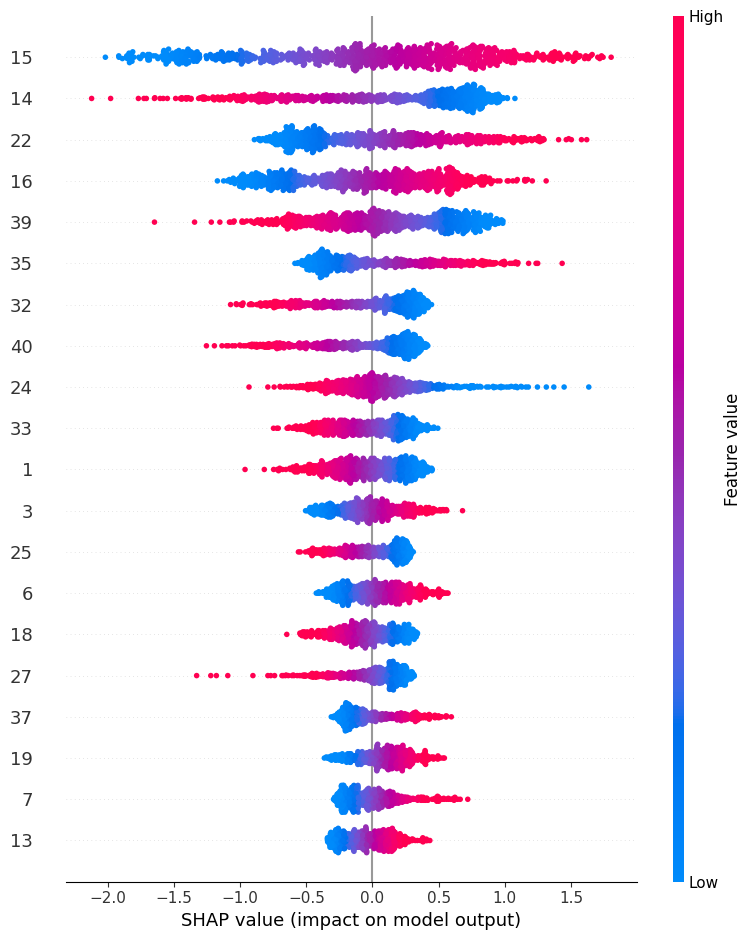

In [5]:
from sklearn.metrics import *



def model_log_odds(x):
	p = model.predict_log_proba(x)
	return p[:,1] - p[:,0]

folds = load_existing_split(folds_pickle)
subtype_csvs_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/subtype_csvs'.format(main_path, dataset, meta_folder)
fold = fold_number
df_all = pd.read_csv('{}/{}_{}_leiden_{}_fold{}.csv'.format(subtype_csvs_path, dataset, type_composition, resolution, fold), index_col=0)
df_all.drop('Meso_type_x', axis=1, inplace=True)
df_all.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)

train_fold_samples = folds[fold][0]
val_fold_samples = folds[fold][1]
test_fold_samples = folds[fold][2]
train_df = df_all[df_all['samples'].isin(train_fold_samples)]
test_df = df_all[df_all['samples'].isin(test_fold_samples)]

additional_df = pd.read_csv('{}/{}_{}_leiden_{}_fold{}_additional.csv'.format(subtype_csvs_path, additional_dataset, type_composition, resolution, fold), index_col=0)
additional_df.drop('Meso_type_x', axis=1, inplace=True)
additional_df.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)
features = [x for x in df_all.columns.tolist() if x.isdigit()]


train_labels = np.array(train_df[['Meso_type']].values.astype(int).tolist())
train_labels = OneHotEncoder().fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels = np.array(test_df[['Meso_type']].values.astype(int).tolist())
test_labels = OneHotEncoder().fit_transform(test_labels.reshape(-1,1)).toarray()
additional_labels = np.array(additional_df[['Meso_type']].values.astype(int).tolist())
additional_labels = OneHotEncoder().fit_transform(additional_labels.reshape(-1,1)).toarray()



data = [[train_df[features], train_labels], None, [test_df[features], test_labels], [additional_df[features], additional_labels]]
subsampling = 'oversampling'
# Subsampling the imbalance data
# from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE # SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek # SMOTETomek
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler
if subsampling == 'undersampling':
	smt = EditedNearestNeighbours() #undersampling
elif subsampling == 'oversampling':
	smt = SMOTETomek(random_state=42) #oversampling
else:
	smt = None
	raise ValueError('Subsampling method not recognized.')

for df in data:
	if df is not None:
		df[0], df[1] = smt.fit_resample(df[0], df[1])
		df[1] = OneHotEncoder().fit_transform(df[1].reshape(-1, 1)).toarray()


train, valid, test, additional = data
train_data, train_labels = train
train_labels = train_labels[:,1]

test_data, test_labels = test
test_labels = test_labels[:,1]





# a simple linear model
parameters = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']}
model = sklearn.linear_model.LogisticRegression(max_iter=100000)
clf = sklearn.model_selection.GridSearchCV(model, parameters, cv=5)
# clf.fit(train_df[features], train_df['Meso_type'])
clf.fit(train_data, train_labels)
print(clf.best_params_)

model = sklearn.linear_model.LogisticRegression(penalty=clf.best_params_['penalty'], C=clf.best_params_['C'], solver=clf.best_params_['solver'], max_iter=100000)
# model.fit(train_df[features], train_df['Meso_type'])
model.fit(train_data, train_labels)
# print('auc:', sklearn.metrics.roc_auc_score(test_df['Meso_type'], model.predict_proba(test_df[features])[:,1]))
print('auc:', sklearn.metrics.roc_auc_score(test_labels, model.predict_proba(test_data)[:,1]))

# complete_df = pd.concat([test_df], axis=0)
complete_df = pd.concat([test_data], axis=0)
data_plot = complete_df[features]
data_plot.columns = data_plot.columns.astype(str)

# explainer = shap.Explainer(model_log_odds, test_df[features], max_samples=test_df.shape[0])
explainer = shap.Explainer(model_log_odds, train_data, max_samples=train_data.shape[0])
shap_values = explainer(data_plot)
shap.summary_plot(shap_values)


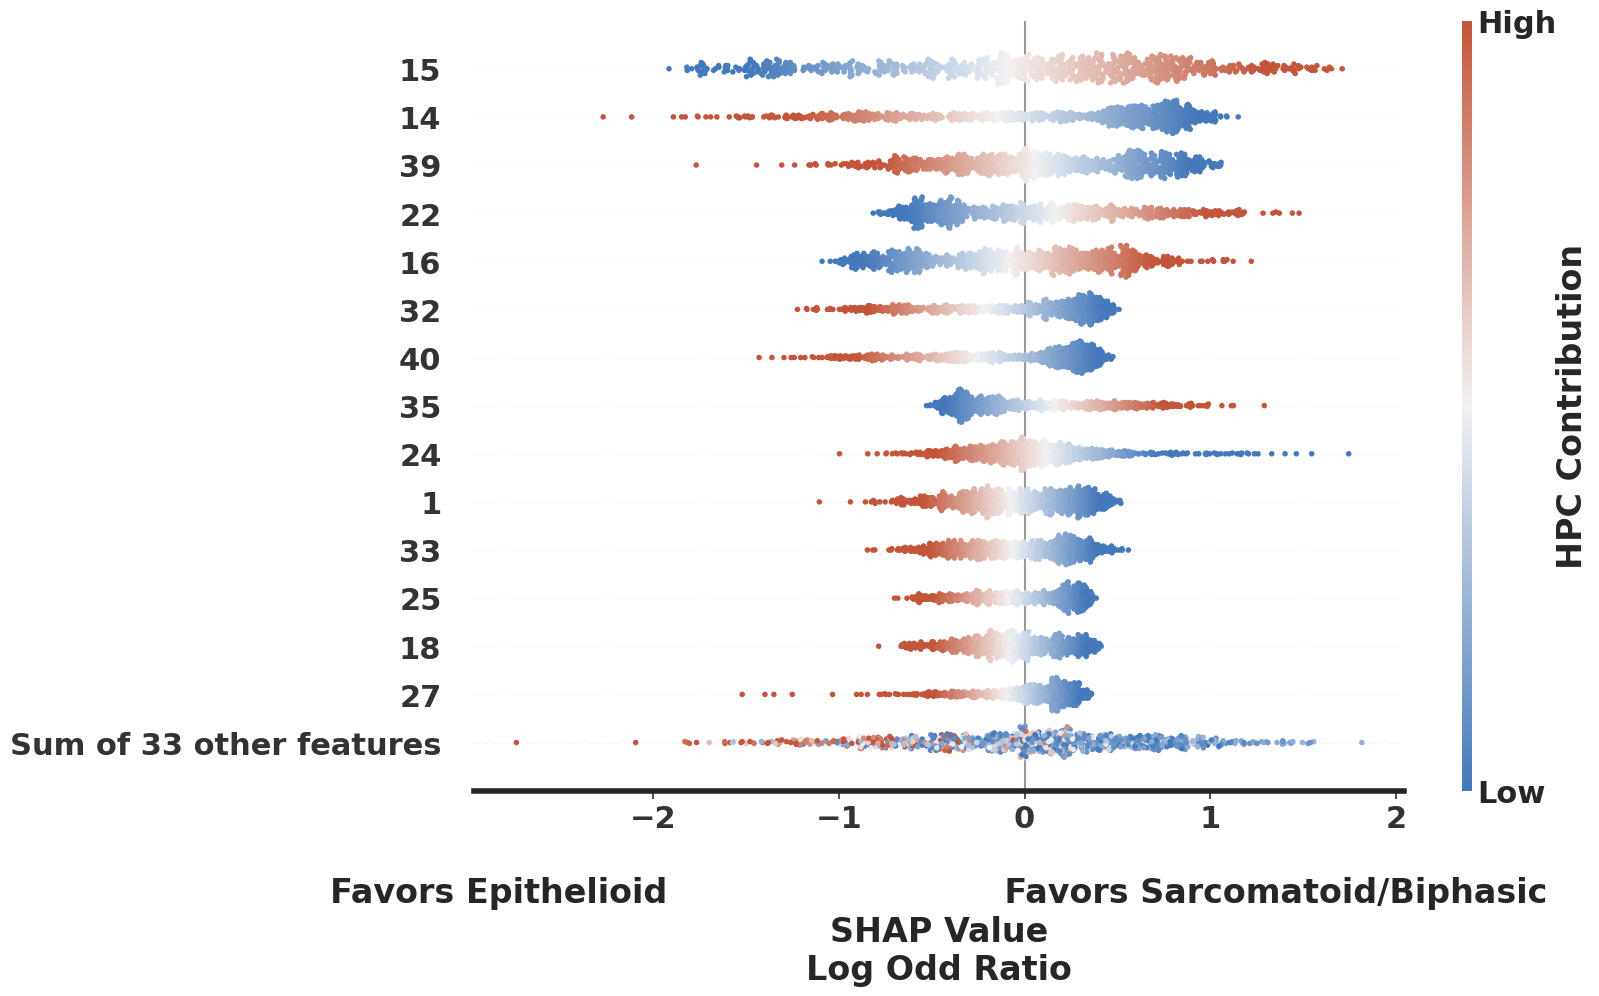

In [20]:
text1 = '\nFavors Epithelioid'
text2 = 'Favors Sarcomatoid/Biphasic\nSHAP Value\nLog Odd Ratio'

plot_shap_figure_simple(shap_values, text1=text1, text2=text2, plot_size=(15,10), fontsize_labels=24, fontsize_ticks=22, offset=100, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True), path=figure_path + 'subtype.jpg')

# Cox Survival Modeling

In [6]:
# Removing the clusters manually
# leiden 1p5 fold 4
remove_1p5 = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
hpc_1p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

# leiden 2p0 fold 4
hpc_2p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
remove_2p0 = [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 
# back to normal to get the association with all the clusters for the HR plot
remove_2p0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 2p5 fold 4
hpc_2p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
remove_2p5 = [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# leiden 3p0 fold 4
hpc_3p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
remove_3p0 = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 4p0 fold 4
hpc_4p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
remove_4p0 = [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

dict_removal = {'1p5':[remove_1p5, hpc_1p5], '2p0':[remove_2p0, hpc_2p0], '2p5':[remove_2p5, hpc_2p5], '3p0':[remove_3p0, hpc_3p0], '4p0':[remove_4p0, hpc_4p0]}


event_ind_field = 'os_event_ind'
event_data_field = 'os_event_data'
resolution = '2p0'
groupby        = 'leiden_%s' % resolution
fold_number = 4


# For Kaplan-Meier Plots
matching_field = 'case_Id'
num_folds = 5
dataset = 'Meso'
meta_folder = '750K'

In [7]:
penalizer = .5
l1_ratio = .1
sns.set_theme(style="whitegrid")
cis_list = []
fold = fold_number
train_risk = [pd.DataFrame(), pd.DataFrame()]
test_risk = [pd.DataFrame(), pd.DataFrame()]
additional_risk = [pd.DataFrame(), pd.DataFrame()]

train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
# # Just Sarc/Biphasic cases.
# train = train[train['Meso_type'] == 1]
# Just Epithelioid cases.
# train = train[train['Meso_type'] == 0]

test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
# Just Sarc/Biphasic cases.
# test = test[test['Meso_type'] == 1]
# Just Epithelioid cases.
# test = test[test['Meso_type'] == 0]

additional = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
# Just Sarc/Biphasic cases.
# additional = additional[additional['Meso_type'] == 1]
# Just Epithelioid cases.
# additional = additional[additional['Meso_type'] == 0]


# remove this column from the train and test data
leiden_clusters = []
hpc, remove = dict_removal[resolution][1], dict_removal[resolution][0]
for cluster, removal in zip(hpc, remove):
        if not removal: leiden_clusters.append(str(cluster))

train_df = train[leiden_clusters + [event_data_field, event_ind_field]]
test_df = test[leiden_clusters + [event_data_field, event_ind_field]]
additional_df = additional[leiden_clusters + [event_data_field, event_ind_field]]
features = [x for x in train_df.columns.tolist() if x.isdigit()]
leiden_clusters = [str(x) for x in features]

cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
cph.fit(train_df, duration_col=event_data_field, event_col=event_ind_field, robust=True)
cis_list.append(cph.score(train_df, scoring_method='concordance_index'))
cis_list.append(cph.score(test_df, scoring_method='concordance_index'))
cis_list.append(cph.score(additional_df, scoring_method='concordance_index'))

train_df = train[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
test_df = test[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
additional_df = additional[leiden_clusters + [event_data_field, event_ind_field, matching_field]]

datas = [(train_df, 'train'), (test_df, 'test'), (additional_df, 'additional')]

train_preds = cph.predict_partial_hazard(train_df)
test_preds = cph.predict_partial_hazard(test_df)
additional_preds = cph.predict_partial_hazard(additional_df)

predictions = [(train_preds,'train'), (test_preds,'test'), (additional_preds,'additional')]

explainer = shap.Explainer(cph.predict_log_partial_hazard, train[features], max_samples=train.shape[0])
complete_df = pd.concat([test, train], axis=0)
shap_values = explainer(complete_df[features])


high_lows = get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2)

# train_risk, test_risk, additional_risk = combine_risk_groups(train_risk, test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field)





PermutationExplainer explainer: 487it [00:34,  9.97it/s]                         


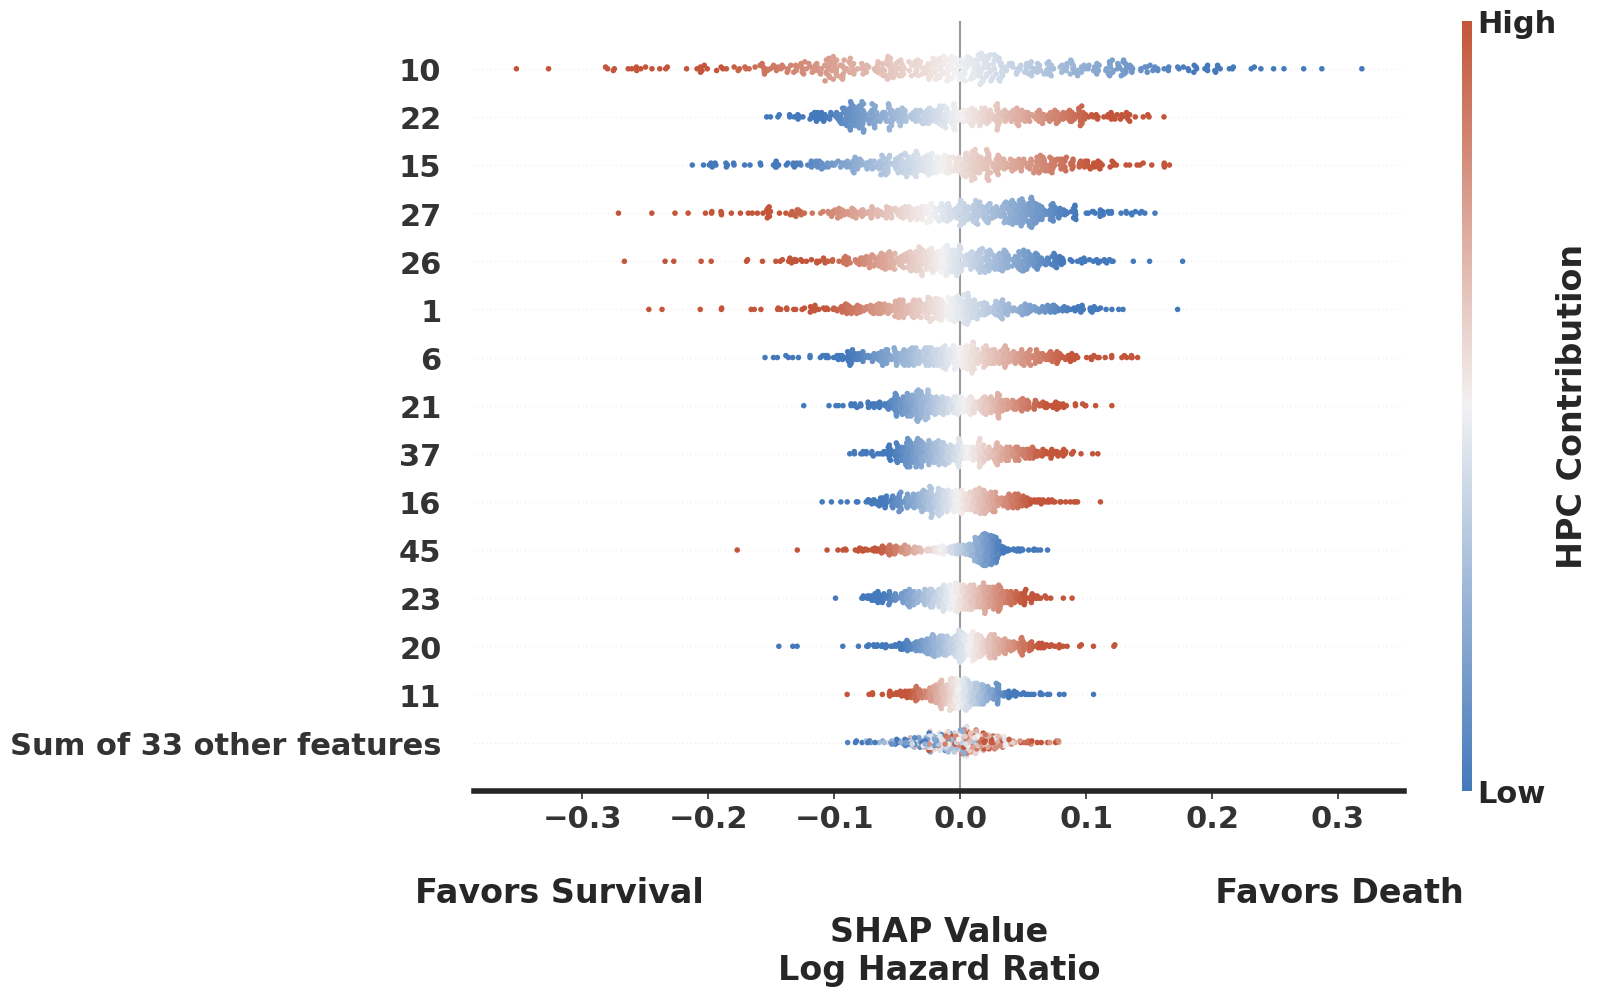

In [23]:
text1 = '\nFavors Survival'
text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
plot_shap_figure_simple(shap_values, offset=100, text1=text1,text2=text2, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True), plot_size=(15,10), path=figure_path + 'survival_epith.jpg')

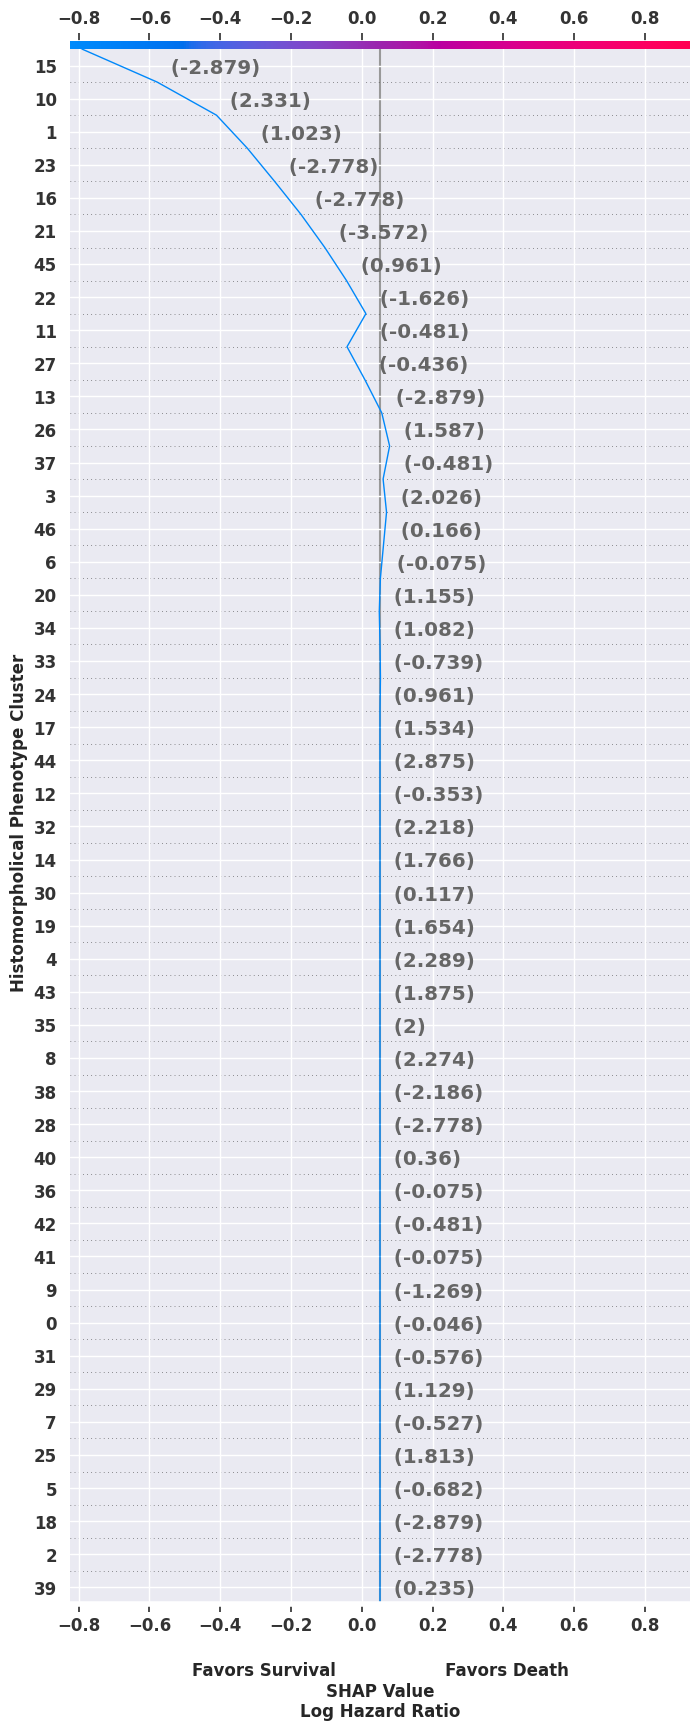

In [9]:
# Shap figure.
sns.set_theme(palette='flare')
sns.set_palette('flare')
num_features    = 'all'
# num_features    = 5
# num_samples     = 10
fontsize_labels = 12
fontsize_ticks  = 12
fontsize_legend = 8
l_box_w         = 3
offset=75
show_legend = True

# Shap figure.
text1 = '\nFavors Survival'
text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2
low_risk_df, high_risk_df, complete = high_lows[1][1], high_lows[1][0], pd.concat([test, train], axis=0)
low_risk_df, high_risk_df = low_risk_df.sort_values(by='hazard'), high_risk_df.sort_values(by='hazard')

# lowest risk
xlim = plot_shap_decision(shap_values.base_values, shap_values.values, complete[features], low_risk_df.index[0:1], None ,num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim=None, path='temp_lowest_risk.pdf')


(-0.8245406934480554, 0.9275323571835027)

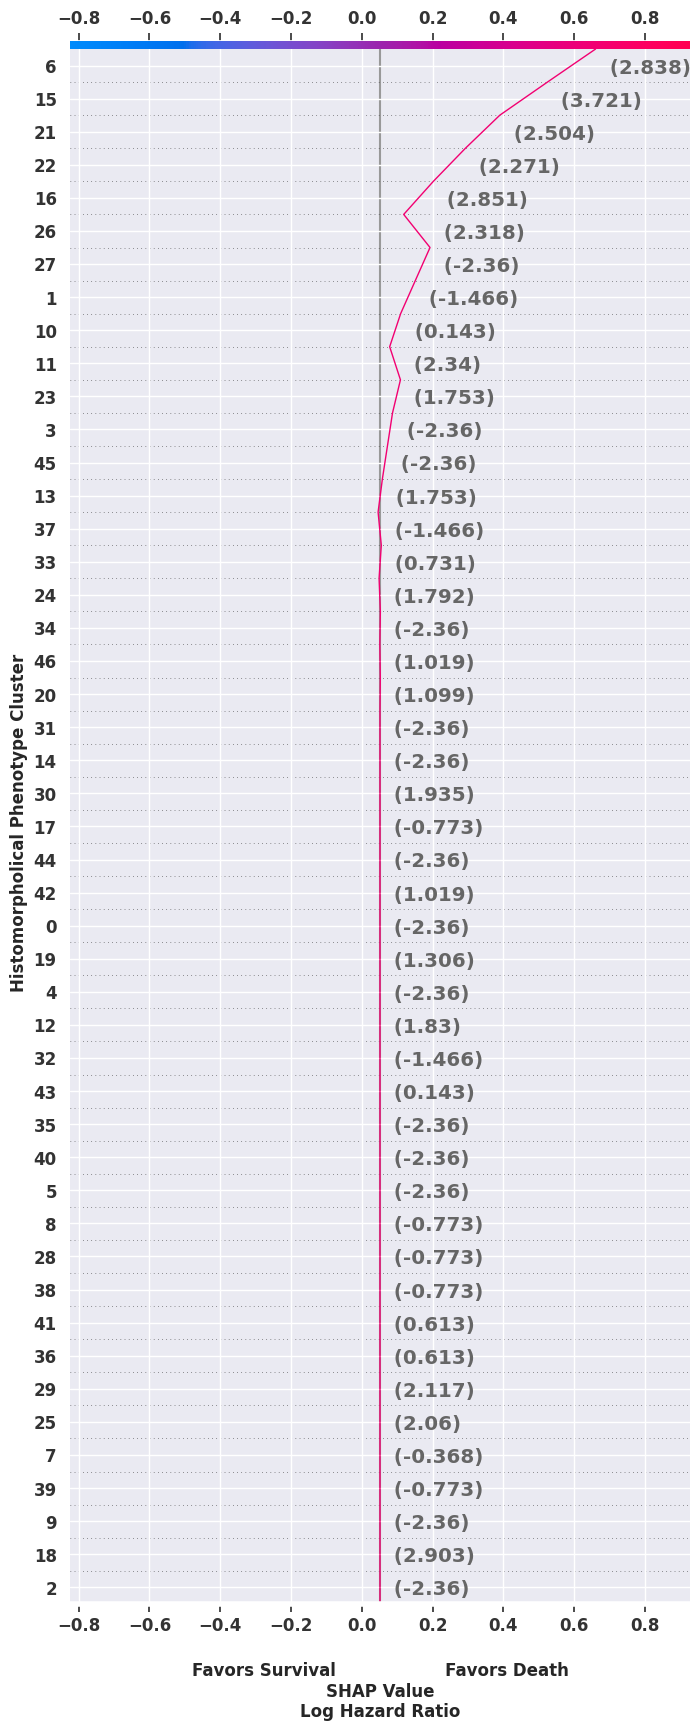

In [10]:
plot_shap_decision(shap_values.base_values, shap_values.values, complete[features], None, high_risk_df.index[-1:] ,num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim=xlim, path='temp_highest_risk.pdf')
# save the related dataframes


In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import sys
sys.path.append(main_path)
from models.clustering.data_processing import *

h5_complete_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, 'Meso', 'Meso')
meta_folder = '750K'
groupby = 'leiden_2.0'
fold_number = 4
figure_path = main_path + '/workflow/figures/HPC_figures/cluster_tile/'
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)
os.makedirs(figure_path, exist_ok=True)

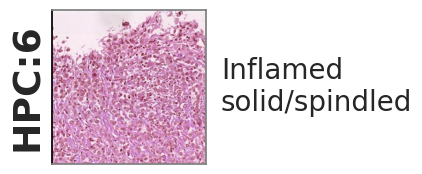

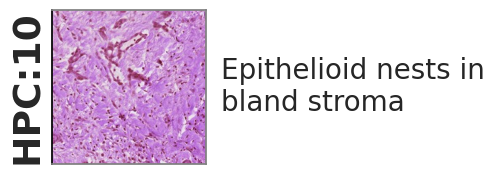

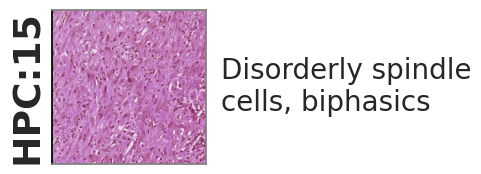

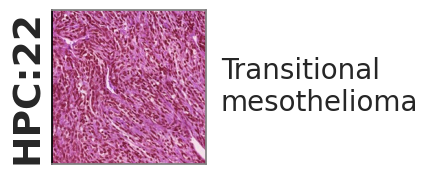

In [ ]:
import textwrap
sns.set_style("dark")
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()

# cluster_set = leiden_clusters
cluster_set = ['6','10','15', '22']
for cluster_number in cluster_set:
    indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
    i_rand = np.random.randint(0, len(indexes))
    index_ = indexes[i_rand]
    set_ = sets[i_rand]
    if set_ == 'valid': set_address = 'validation' 
    else: set_address = set_
    h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
    h5_image = h5py.File(h5_image_path, 'r')
    image = h5_image['{}_img'.format(set_)][int(index_)]
    

    # #  2*2 grid. 4 tile for each cluster.
    # fig, ax = plt.subplots(1, 1, figsize=(2,2))
    # ax.imshow(image)
    # ax.axis('off')
    # ax.set_title('HPC %s' % cluster_number, fontsize=15, fontweight='bold')
    # # fig.suptitle('HPC %s' % cluster_number, fontsize=15, fontweight='bold')
    # plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    # plt.savefig(figure_path + '/{}/HPC_{}_tiles_some.png'.format(fldr_nm, cluster_number), bbox_inches='tight', dpi=300)
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    if image is not None:
        ax.imshow(image)
    else:
        cluster_number = cluster_number.split('_')[0]
    ax.set(xticks=[], yticks=[])


    ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=27))
    ax.set_axis_on()
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    pos = ax.get_position()
    ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])


    annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 20)
    label_text = annotation_text
    ax.text(1.1, .5, label_text,
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size="20" )
    
    plt.savefig(figure_path + 'cluster_{}.png'.format(cluster_number), bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

h5_image.close()
# plt.show()